In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## 1.) Camera Calibration

In [2]:
def camera_calibration():
    
    images=glob.glob('camera_cal/calibration*.jpg')

    obj_points=[]#3d points in the real world
    img_points=[]#takes 2d points from image plane

    obj_p=np.zeros((6*9,3),np.float32)
    obj_p[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:
        img=mpimg.imread(fname)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(9,6),None)##

        if ret:
            img_points.append(corners)
            obj_points.append(obj_p)

            img=cv2.drawChessboardCorners(img,(9,6),corners,ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    
    return obj_points,img_points,gray

In [3]:
obj_points,img_points,gray=camera_calibration()

In [4]:
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(obj_points,img_points,gray.shape[::-1],None,None)


 Testing the code to undistort the road images

In [5]:
img_test=mpimg.imread('test_images/test3.jpg')

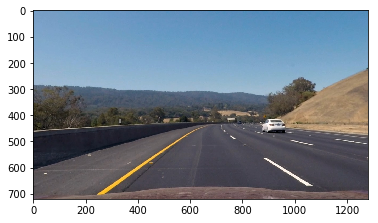

In [6]:
undistort_test=cv2.undistort(img_test,mtx,dist,None,mtx)
plt.imshow(undistort_test)
plt.show()

In [124]:
plt.imsave('output_images/undistort_test.png',undistort_test)

## 2.) Color transforms and gradients

In [8]:
def pipeline(img,s_threshold=(170,255),gray_threshold=(20,100)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 120
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel < s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary

In [9]:
color_binary_output,combined_binary_output=pipeline(undistort_test)

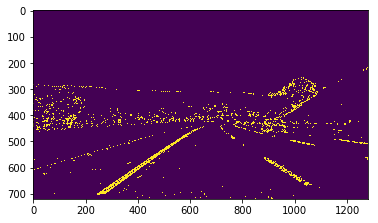

In [10]:
plt.imshow(combined_binary_output)
plt.show()

In [11]:
plt.imsave('output_images/color_binary_output.png',color_binary_output)
plt.imsave('output_images/combined_binary_output.png',combined_binary_output)


## 3.)  Perspective Transform

In [12]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

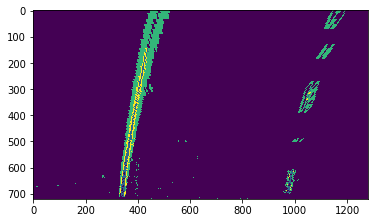

In [13]:
img=cv2.imread('output_images/color_binary_output.png')
#img=cv2.imread('output_images/combined_binary_output.png')

img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)


img_size=(img.shape[1],img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

warped_in=warper(img,src,dst)
plt.imshow(warped_in)
plt.show()

#cv2.imwrite('output_images/color_binary_birds_viewc.jpg',warped_in)
plt.imsave('output_images/color_binary_birds_viewc_plt.png',warped_in)


In [14]:
Minv=cv2.getPerspectiveTransform(dst,src)

In [15]:
warped_in.shape

(720, 1280)

# 4.) Identified lane-line pixels and fit their positions with a polynomial?

In [16]:
#warped = cv2.imread('output_images/color_binary_birds_view.jpg')

In [17]:
def find_lane_pixels(binary_warped):
    
    #binary_warped=binary_warped[:,:,0]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =  leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high =rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit,left_fitx,right_fitx,ploty


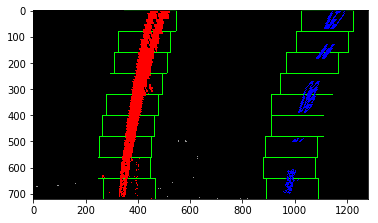

In [18]:
out_img,left_fit,right_fit,left_fitx,right_fitx,ploty = fit_polynomial(warped_in)
plt.imshow(out_img)
plt.show()

In [19]:
#cv2.imwrite('output_images/lane_line_sliding_window.png',out_img)
plt.imsave('output_images/lane_line_sliding_window_plt.png',out_img)


## 5.) Calculated the radius of curvature of the lane and position of the vehicle with respect to center

In [68]:
def measure_curvature_pixels(left_fit, right_fit,ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)#719
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 #  meters per pixel in x dimension
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    distance_from_center=(left_curverad+ right_curverad)/2
    
    string='The Radius of Curvature = '+str(int(distance_from_center))+'m'
    
    return string


In [69]:
distance_from_center=measure_curvature_pixels(left_fit, right_fit,ploty)
distance_from_center

'The Radius of Curvature = 4125m'

In [76]:
def difference_from_center(warped_in):
    histogram = np.sum(warped_in[warped_in.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    center_of_image=(leftx_base+rightx_base)/2
    center_of_lane=warped_in.shape[1]//2
    difference_from_center=(center_of_image-center_of_lane)
    xm_per_pix = 3.7/1280 

    if difference_from_center>0:
        string='Vehicle is right of the center = '+str(xm_per_pix*difference_from_center)+'m'
        return string
    else:
        string='Vehicle is left of the center = '+ str(xm_per_pix*-difference_from_center)+'m'
        return string


In [77]:
string=difference_from_center(warped_in)
string

'Vehicle is right of the center = 0.1141796875m'

## 6.) Lane area is identified

In [78]:
def identify_lane(warped_in,undistort_test,left_fitx,right_fitx,ploty):
    warp_zero = np.zeros_like(warped_in).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    img_size=(warped_in.shape[1],warped_in.shape[0])
       
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    Minv=cv2.getPerspectiveTransform(dst,src)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result_image = cv2.addWeighted(undistort_test, 1, newwarp, 0.3, 0)
    
    return result_image

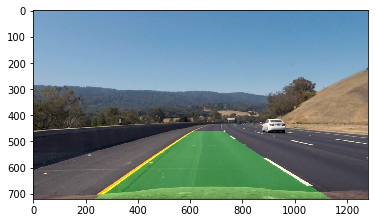

In [79]:
result_image=identify_lane(warped_in,undistort_test,left_fitx,right_fitx,ploty)
plt.imshow(result_image)
plt.show()

In [26]:
import imageio
imageio.plugins.ffmpeg.download()

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [171]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #print(image.shape)
    
    undistort_test=cv2.undistort(image,mtx,dist,None,mtx)
    
    
    color_binary_output,_=pipeline(undistort_test)
    img = cv2.cvtColor(color_binary_output,cv2.COLOR_RGB2GRAY)
    
    img_size=(img.shape[1],img.shape[0])
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    Minv=cv2.getPerspectiveTransform(dst,src)
    warped_in=warper(img,src,dst)
    
    out_img,left_fit,right_fit,left_fitx,right_fitx,ploty = fit_polynomial(warped_in)
    
    
    
    distance_from_center=measure_curvature_pixels(left_fit, right_fit,ploty)
    
    string=difference_from_center(warped_in)
    
    left_fitx,right_fitx,ploty
   
    result_image=identify_lane(warped_in,undistort_test,left_fitx,right_fitx,ploty)
    
    font                   = cv2.FONT_ITALIC 
    fontScale              = 1
    fontColor              = (0,0,0)
    lineType               = 1
    
    
    result_image=cv2.putText(result_image,distance_from_center,(100,50),font,fontScale,fontColor,1)
    result_image=cv2.putText(result_image,string,(100,80),font,fontScale,fontColor,1)
    
    
    return result_image

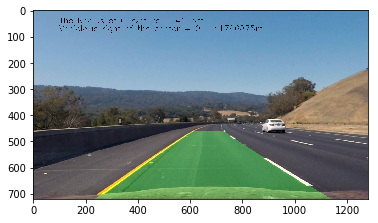

In [172]:
test_image=mpimg.imread('test_images/test3.jpg')
result_image=process_image(test_image)
plt.imshow(result_image)
plt.show()
plt.imsave('rough.png',result_image)

In [173]:
white_output = 'project_video_post_processing.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,49)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1225/1226 [03:15<00:00,  6.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 7min 23s, sys: 14.3 s, total: 7min 37s
Wall time: 3min 17s


In [122]:
HTML("""<video width="960" height="540" controls> <source src="{0}"></video>""".format(white_output))